In [1]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 34.3 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split


from sklearn.model_selection import cross_val_predict,cross_val_score


from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
import os
import matplotlib.pyplot as plt

import gensim
import re
from numpy import array
from numpy import asarray
from numpy import zeros

from keras.models import Sequential
from keras.layers import Dense

from keras.layers import Embedding
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,GlobalMaxPooling1D

from keras import backend as K
from kerastuner import HyperModel
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
word2vemodel = gensim.models.Word2Vec.load('/content/drive/MyDrive/ArabicSentimentHager/full_grams_cbow_300_twitter.mdl')

## Read training dataset

In [7]:
#read train dataset
train=  pd.read_csv('/content/drive/MyDrive/ArabicSentimentHager/paper1/deep/dataset2/train_datasetset2.csv',encoding='utf-8')
train=train.dropna()

y_train1 = train.label                           
X_train= train.drop('label',axis = 1 )

train.label.value_counts()

1    794
0    766
Name: label, dtype: int64

##Read testing dataset

In [8]:
#read testing dataset
test= pd.read_csv('/content/drive/MyDrive/ArabicSentimentHager/paper1/deep/dataset2/unseen_dataset2.csv',encoding='utf-8')
test=test.dropna()

y_test1= test.label                           
X_test= test.drop('label',axis = 1 )
test.label.value_counts()

1    199
0    192
Name: label, dtype: int64

## convert label to categorical

In [9]:
#convert label to categorical
encoder_train_y = LabelEncoder()
y_train= encoder_train_y.fit_transform(y_train1)
y_train_categorical = np_utils.to_categorical(y_train)

encoder_test_y = LabelEncoder()
y_test = encoder_test_y.fit_transform(y_test1)
y_test_categorical=np_utils.to_categorical(y_test)

## Convert x_train and X_test into number

In [10]:
MAX_LEN = 140  # cut texts after this number of words (among top max_features most common words)
BATCH_SIZE = 2000
MAX_NUM_WORDS = 200000
EMBEDDING_DIM = 300
epoch=20


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train['text'])
train_sequences = tokenizer.texts_to_sequences(X_train['text'])

word_index = tokenizer.word_index
padded_train = pad_sequences(sequences=train_sequences, maxlen=MAX_LEN)

test_sequences = tokenizer.texts_to_sequences(X_test['text'])
padded_test = pad_sequences(sequences=test_sequences, maxlen=MAX_LEN)

print('Total unique tokens generated: ',len(word_index))
print('Shape of padded train tensor: ', padded_train.shape)
print('Shape of padded test tensor: ', padded_test.shape)

Total unique tokens generated:  5874
Shape of padded train tensor:  (1560, 140)
Shape of padded test tensor:  (391, 140)


## Bulid embedding_matrix

In [11]:
num_words = min(MAX_NUM_WORDS, len(word_index))
word_embedding_matrix = np.zeros((num_words + 1, EMBEDDING_DIM))

for word, index in word_index.items():
    if index > MAX_NUM_WORDS:
        continue
    # embedding_vector = model[word]
    #word = clean_str(word)
    if word not in word2vemodel.wv:
        embedding_vector = None
    else:
        embedding_vector = word2vemodel.wv[word]
    if embedding_vector is not None:
        word_embedding_matrix[index] = embedding_vector

## Define some of function that are used as matixs 

In [12]:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Optimize and build mode 

In [13]:
def build_model(hp):
    num_units_min  =  50
    num_units_max  =  1000
    num_units_step =  50

    dropout_min  =  .1
    dropout_max  =  0.9
    dropout_step =  0.1
    
    model = keras.Sequential()
 
    model.add(layers.Embedding(num_words + 1, EMBEDDING_DIM, weights=[word_embedding_matrix], input_length=MAX_LEN))

    
    model.add(layers.LSTM(units=hp.Int('unit1',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step), return_sequences = False,
                          kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate1',values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6,0.05 ,.2,.3,.4,.5,0.6,0.7,0.8])) ))
    model.add(layers.Dropout(hp.Float('dropout_1',min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step) ) )
   
    
    model.add(layers.Flatten())
  
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[ 1e-4])),loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
    return model


In [19]:

tuner = RandomSearch(
    build_model,
    objective='val_acc',
    max_trials=5,
    project_name="/content/drive/MyDrive/ArabicSentimentHager/paper1/deep/dataset2/LSTM")


In [20]:
epoch=20
BATCH_SIZE=1500
early_stopping = EarlyStopping(monitor='val_acc', patience=30, verbose=1)
callback_list = [ early_stopping ]

# split training data into stratified train/dev sets

h=tuner.search(padded_train, y_train_categorical,
             epochs=epoch,
             batch_size=BATCH_SIZE, 
             callbacks=callback_list, validation_data=(padded_test,y_test_categorical) )
            
model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 00m 50s]
val_acc: 0.7800511717796326

Best val_acc So Far: 0.810741662979126
Total elapsed time: 00h 02m 19s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.get_best_hyperparameters()[0].values

{'dropout_1': 0.2, 'learning_rate': 0.0001, 'reg_rate1': 0.0001, 'unit1': 300}

In [22]:
AccuracyTrain=[]
PrecisionTrain=[]
RecallTrain=[]
F1Train=[]

from sklearn.model_selection import KFold 

for i in range(0,1):    
    if i==0:
        r=70
    elif i== 1:
        r=140
    
    kf = KFold(n_splits=10,random_state=r,shuffle=True) 
    for train_index, test_index in kf.split(padded_train):
        X_t, X_val = padded_train[train_index], padded_train[test_index] 
        y_t, y_val = y_train_categorical[train_index], y_train_categorical[test_index]
        h=model.fit(X_t, y_t, epochs=epoch, batch_size=BATCH_SIZE,  verbose=1, shuffle=True, validation_data=(X_val,y_val))

        AccuracyTrain.append(round(100*np.mean(h.history['val_acc']),2))
        PrecisionTrain.append(round(100*np.mean(h.history['val_precision_m']),2))
        RecallTrain.append(round(100*np.mean(h.history['val_recall_m']),2))
        F1Train.append(round(100*np.mean(h.history['val_f1_m']),2))
      

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.4616 - acc: 0.8547 - f1_m: 0.8547 - precision_m: 0.8547 - recall_m: 0.8547 - val_loss: 0.4401 - val_acc: 0.8846 - val_f1_m: 0.8846 - val_precision_m: 0.8846 - val_recall_m: 0.8846
Epoch 2/20
1/1 [==============================] - 0s 347ms/step - loss: 0.4572 - acc: 0.8483 - f1_m: 0.8483 - precision_m: 0.8483 - recall_m: 0.8483 - val_loss: 0.4371 - val_acc: 0.8846 - val_f1_m: 0.8846 - val_precision_m: 0.8846 - val_recall_m: 0.8846
Epoch 3/20
1/1 [==============================] - 0s 362ms/step - loss: 0.4532 - acc: 0.8575 - f1_m: 0.8575 - precision_m: 0.8575 - recall_m: 0.8575 - val_loss: 0.4341 - val_acc: 0.8846 - val_f1_m: 0.8846 - val_precision_m: 0.8846 - val_recall_m: 0.8846
Epoch 4/20
1/1 [==============================] - 0s 370ms/step - loss: 0.4522 - acc: 0.8597 - f1_m: 0.8597 - precision_m: 0.8597 - recall_m: 0.8597 - val_loss: 0.4313 - val_acc: 0.8782 - val_f1_m: 0.8782 - val_precision_m: 0.8782 - val_reca

In [23]:
AccuracyTest=[]
PrecisionTest=[]
RecallTest=[]
F1Test=[]
for i in range(0,1): 
    model.fit(padded_train, y_train_categorical, epochs=epoch, batch_size=BATCH_SIZE,  verbose=1, shuffle=True)
    y_p = model.predict(padded_test)
    y_pred= np.argmax(y_p, axis=1)

    Accurcy_Test= accuracy_score(y_test,y_pred)
    Precision_Test=precision_score(y_test, y_pred,average='weighted')

    Recall_Test=recall_score(y_test, y_pred, average='weighted')
    F1_Test=f1_score(y_test, y_pred, average='weighted') 

    AccuracyTest.append(round(100*Accurcy_Test, 2))
    PrecisionTest.append(round(100*Precision_Test, 2))
    RecallTest.append(round(100*Recall_Test, 2))
    F1Test.append(round(100*F1_Test, 2))

Epoch 1/20
2/2 [==============================] - 0s 26ms/step - loss: 0.1344 - acc: 0.9750 - f1_m: 0.9550 - precision_m: 0.9550 - recall_m: 0.9550
Epoch 2/20
2/2 [==============================] - 0s 28ms/step - loss: 0.1340 - acc: 0.9801 - f1_m: 0.9817 - precision_m: 0.9817 - recall_m: 0.9817
Epoch 3/20
2/2 [==============================] - 0s 30ms/step - loss: 0.1320 - acc: 0.9827 - f1_m: 0.9670 - precision_m: 0.9670 - recall_m: 0.9670
Epoch 4/20
2/2 [==============================] - 0s 26ms/step - loss: 0.1310 - acc: 0.9833 - f1_m: 0.9913 - precision_m: 0.9913 - recall_m: 0.9913
Epoch 5/20
2/2 [==============================] - 0s 27ms/step - loss: 0.1300 - acc: 0.9846 - f1_m: 0.9920 - precision_m: 0.9920 - recall_m: 0.9920
Epoch 6/20
2/2 [==============================] - 0s 29ms/step - loss: 0.1289 - acc: 0.9872 - f1_m: 0.9853 - precision_m: 0.9853 - recall_m: 0.9853
Epoch 7/20
2/2 [==============================] - 0s 28ms/step - loss: 0.1280 - acc: 0.9865 - f1_m: 0.9930 - pre

In [24]:
finaltrain = pd.DataFrame([])

finaltrain = finaltrain.append({'AccuracyTrain' : round(np.mean(AccuracyTrain),2),
                                'PrecisionTrain':round(np.mean(PrecisionTrain),2),
                                'RecallTrain':round(np.mean(RecallTrain),2) ,
                                'F1Train':round(np.mean(F1Train),2) 
                               
                               } , ignore_index=True)

finaltrain.reindex(['AccuracyTrain','PrecisionTrain','RecallTrain','F1Train'], axis=1)

,AccuracyTrain,PrecisionTrain,RecallTrain,F1Train
0,93.58,93.58,93.58,93.58


In [25]:
ReultofTest=pd.DataFrame([])
ReultofTest=ReultofTest.append({'AccuracyTest' : round(np.mean(AccuracyTest),2),'PrecisionTest':round(np.mean(PrecisionTest),2),
             'RecallTest' : round(np.mean(RecallTest),2),'F1Test':round(np.mean(F1Test),2)}, ignore_index=True)

ReultofTest.reindex(['AccuracyTest','PrecisionTest','RecallTest','F1Test'], axis=1)

,AccuracyTest,PrecisionTest,RecallTest,F1Test
0,84.91,84.96,84.91,84.91


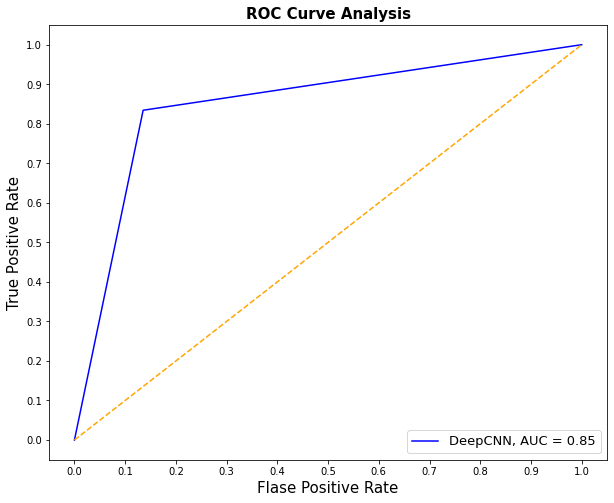

In [26]:
import sklearn.metrics as metrics


fig = plt.figure(figsize=(10,8))

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = round(np.mean(metrics.auc(fpr, tpr)),2)


plt.plot(fpr, tpr, 'b', label = 'DeepCNN, AUC = %0.2f' % roc_auc)

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()